# Step 1: Import Necessary Libraries

In [249]:
import pandas as pd
import re
from sklearn.model_selection import cross_val_score, KFold
from sklearn.metrics import mean_squared_error, make_scorer, r2_score

from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
import data_preprocessing_emlakjet as dpe
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import train_test_split

import matplotlib.pyplot as plt
import seaborn as sns
from nltk.tokenize import word_tokenize
from nltk.probability import FreqDist
from transformers import pipeline, AutoTokenizer, AutoModelForSequenceClassification
import torch
from scipy.sparse import hstack
import numpy as np
import nltk
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import StandardScaler

In [250]:
# Ensure NLTK resources are available
nltk.download('stopwords')
nltk.download('punkt')

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/mhsendur/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /Users/mhsendur/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

# Step 2: Load and Prepare the Data

## Load the JSON data

In [251]:

# Load the raw data
raw_data = dpe.load_json_data('istanbul_emlakjet_all_records_updated.json')

# Preprocess the data
processed_data = dpe.cleanse_and_preprocess_data(raw_data)

df = pd.DataFrame(processed_data)

# Display the first few rows of the DataFrame
df.head()


,id,categoryTypeName,tradeTypeName,estateTypeName,title,url,images,locationSummary,quickInfos,priceDetail,description,info,location
0,14869600,konut,satılık,yazlık,satılık 4+1 bahçe katı yazlık daire,https://imaj.emlakjet.com/ilan/satilik-41-bahc...,[https://imaj.emlakjet.com/listing/14869600/74...,adalar - kınalıada mahallesi,Oda Sayısı: 4+1; Bulunduğu Kat: Bahçe katı,"{'trendType': None, 'previousCurrency': None, ...",tekinay'da satılık 4+1 bahçe katı yazlık daire...,"{'id': '14869600', 'created_at': '2024-03-17',...","{'summary': 'Adalar - Kınalıada Mahallesi', 'c..."
1,14794365,konut,satılık,daire,büyükada i̇do i̇skelesine yakın konumda 3+1 bl...,https://imaj.emlakjet.com/ilan/buyukada-ido-is...,[https://imaj.emlakjet.com/listing/14794365/4E...,adalar - nizam mahallesi,Oda Sayısı: 3+1; Bulunduğu Kat: Düz Giriş (Zemin),"{'trendType': None, 'previousCurrency': None, ...",mega emlak'tan \n\nbüyükada yi̇rmi̇üç ni̇san c...,"{'id': '14794365', 'created_at': '2024-03-02',...","{'summary': 'Adalar - Nizam Mahallesi', 'city'..."
2,14780556,konut,satılık,daire,heybeliada muhteşem deniz manzaralı sahile yak...,https://imaj.emlakjet.com/ilan/heybeliada-muht...,[https://imaj.emlakjet.com/listing/14780556/1F...,adalar - heybeliada mahallesi,Oda Sayısı: 4+1; Bulunduğu Kat: 4. Kat,"{'trendType': None, 'previousCurrency': None, ...",heybeliada’da tamamen yenilenmiş deniz manzara...,"{'id': '14780556', 'created_at': '2024-02-28',...","{'summary': 'Adalar - Heybeliada Mahallesi', '..."
3,14780555,konut,satılık,daire,adalar heybeliada’da satılık 3+1 kat mülkiyetli,https://imaj.emlakjet.com/ilan/adalar-heybelia...,[https://imaj.emlakjet.com/listing/14780555/28...,adalar - heybeliada mahallesi,Oda Sayısı: 3+1; Bulunduğu Kat: 3. Kat,"{'trendType': None, 'previousCurrency': None, ...",heybeliada’da satılık 3+1kat mülkiyetli\n\nhey...,"{'id': '14780555', 'created_at': '2024-02-28',...","{'summary': 'Adalar - Heybeliada Mahallesi', '..."
4,14771773,konut,satılık,yalı,prenses adalari heybeli̇de muhteşem deni̇z yal...,https://imaj.emlakjet.com/ilan/prenses-adalari...,[https://imaj.emlakjet.com/listing/14771773/BD...,adalar - heybeliada mahallesi,Oda Sayısı: 9+ Oda,"{'trendType': None, 'previousCurrency': None, ...",-prenses adalari heybeli̇ adada\n\n250 m2 araz...,"{'id': '14771773', 'created_at': '2024-02-27',...","{'summary': 'Adalar - Heybeliada Mahallesi', '..."


## Data Preparation

In [252]:
print(df.columns)

Index(['id', 'categoryTypeName', 'tradeTypeName', 'estateTypeName', 'title',
       'url', 'images', 'locationSummary', 'quickInfos', 'priceDetail',
       'description', 'info', 'location'],
      dtype='object')


In [253]:
if 'priceDetail' in df.columns:
    price_details = pd.json_normalize(df['priceDetail'])
    df = pd.concat([df.drop(['priceDetail'], axis=1), price_details], axis=1)

if 'info' in df.columns:
    info_details = pd.json_normalize(df['info'])
    df = pd.concat([df.drop(['info'], axis=1), info_details], axis=1)


In [254]:
print(df.columns)

Index(['id', 'categoryTypeName', 'tradeTypeName', 'estateTypeName', 'title',
       'url', 'images', 'locationSummary', 'quickInfos', 'description',
       'location', 'trendType', 'previousCurrency', 'previousPrice',
       'previousValueValid', 'currency', 'price', 'tlPrice',
       'alternativeValue', 'firstPrice', 'differenceRate', 'squareMeterPrice',
       'opportunity', 'id', 'created_at', 'updated_at', 'category',
       'trade_type', 'net_square', 'gross_square', 'room_count', 'build_age',
       'floor_number', 'floor_count', 'heating_type', 'usability',
       'suitability_for_credit', 'suitability_for_investor', 'in_site',
       'build_status', 'build_type', 'deed_status', 'mortgage_status',
       'furniture_status', 'subscription_price', 'loan_price', 'trade',
       'bath_count', 'square_of_bath', 'balcony_condition', 'balcony_count',
       'balcony_type', 'square_of_balcony', 'square_of_room', 'wc_count',
       'square_of_wc', 'block_of_buildings', 'sheet', 'parcel_o

In [255]:
# Display the data types of each column
print(df.dtypes)


id                   int64
categoryTypeName    object
tradeTypeName       object
estateTypeName      object
title               object
                     ...  
parcel_of_land      object
show_unit_price     object
video_navigable     object
ground_survey       object
flat_per_floor      object
Length: 63, dtype: object


In [256]:
# Print out numerical features
numerical_features = df.select_dtypes(include='number').columns
print(numerical_features)


Index(['id', 'previousPrice', 'price', 'tlPrice', 'firstPrice',
       'differenceRate', 'squareMeterPrice', 'net_square', 'gross_square'],
      dtype='object')


## Removing duplicate columns

In [257]:
# Check for duplicate column names
duplicate_columns = df.columns[df.columns.duplicated()]
if len(duplicate_columns) > 0:
    print("Duplicate columns found:", duplicate_columns)


Duplicate columns found: Index(['id'], dtype='object')


In [258]:
# Drop the duplicate column
df.drop(columns=['id'], inplace=True)


In [259]:
duplicate_columns = df.columns[df.columns.duplicated()]
if len(duplicate_columns) > 0:
    print("Duplicate columns found:", duplicate_columns)

In [260]:
print(df.columns)

Index(['categoryTypeName', 'tradeTypeName', 'estateTypeName', 'title', 'url',
       'images', 'locationSummary', 'quickInfos', 'description', 'location',
       'trendType', 'previousCurrency', 'previousPrice', 'previousValueValid',
       'currency', 'price', 'tlPrice', 'alternativeValue', 'firstPrice',
       'differenceRate', 'squareMeterPrice', 'opportunity', 'created_at',
       'updated_at', 'category', 'trade_type', 'net_square', 'gross_square',
       'room_count', 'build_age', 'floor_number', 'floor_count',
       'heating_type', 'usability', 'suitability_for_credit',
       'suitability_for_investor', 'in_site', 'build_status', 'build_type',
       'deed_status', 'mortgage_status', 'furniture_status',
       'subscription_price', 'loan_price', 'trade', 'bath_count',
       'square_of_bath', 'balcony_condition', 'balcony_count', 'balcony_type',
       'square_of_balcony', 'square_of_room', 'wc_count', 'square_of_wc',
       'block_of_buildings', 'sheet', 'parcel_of_land', 'sh

## Flattening lists

In [261]:
# Flatten nested lists in DataFrame
def flatten_nested_lists(df):
    for col in df.columns:
        df[col] = df[col].apply(lambda x: x[0] if isinstance(x, list) else x)
    return df

df = flatten_nested_lists(df)

def flatten_nested_dicts(df):
    for col in df.columns:
        if df[col].apply(lambda x: isinstance(x, dict)).all():
            df[col] = df[col].apply(lambda x: list(x.values())[0])
    return df

df = flatten_nested_dicts(df)

# Define preprocessing steps for numerical and categorical features
numerical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='mean')),  
    ('scaler', StandardScaler())
])

categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),  
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

# Define which columns are numerical and categorical
numerical_features = df.select_dtypes(include='number').columns
categorical_features = df.select_dtypes(include='object').columns

# Combine preprocessing steps
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_transformer, numerical_features),
        ('cat', categorical_transformer, categorical_features)
    ])

# Fit and transform the data
processed_data = preprocessor.fit_transform(df)

# Convert the processed data back to a DataFrame
processed_df = pd.DataFrame(processed_data)


# Step 3: Further Data Cleaning, Preprocessing

In [262]:
# Filling missing values for numerical features with the mean
numerical_cols = df.select_dtypes(include=['float64', 'int64']).columns
df[numerical_cols] = df[numerical_cols].apply(lambda x: x.fillna(x.mean()))

# For categorical features, fill missing values with the mode (most common value)
categorical_cols = df.select_dtypes(include=['object']).columns
df[categorical_cols] = df[categorical_cols].apply(lambda x: x.fillna(x.mode().iloc[0]))


In [263]:
# Define a threshold for rare categories
threshold = 0.01  # Categories with less than 1% frequency will be combined

# Combine rare categories for categoryTypeName
category_type_counts = df['categoryTypeName'].value_counts(normalize=True)
rare_category_types = category_type_counts[category_type_counts < threshold].index
df['categoryTypeName'] = df['categoryTypeName'].apply(lambda x: 'Other' if x in rare_category_types else x)

# Combine rare categories for estateTypeName
estate_type_counts = df['estateTypeName'].value_counts(normalize=True)
rare_estate_types = estate_type_counts[estate_type_counts < threshold].index
df['estateTypeName'] = df['estateTypeName'].apply(lambda x: 'Other' if x in rare_estate_types else x)

df = pd.get_dummies(df, columns=['categoryTypeName', 'estateTypeName'], drop_first=False)


In [264]:
df['build_age'] = df['build_age'].apply(lambda x: int(re.findall('\d+', x)[0]) if pd.notnull(x) else x)


In [265]:
# Function to convert room_count like "4+1" into an integer by summing the parts
def convert_room_count_to_int(room_count):
    if pd.isnull(room_count):
        return None  # Handle missing values
    parts = room_count.split('+')
    try:
        # Convert each part to integer and sum them
        return sum(int(part) for part in parts)
    except ValueError:
        # Handle edge cases where conversion to integer might fail
        return None

df['room_count'] = df['room_count'].apply(convert_room_count_to_int)


In [266]:
df.columns

Index(['tradeTypeName', 'title', 'url', 'images', 'locationSummary',
       'quickInfos', 'description', 'location', 'trendType',
       'previousCurrency', 'previousPrice', 'previousValueValid', 'currency',
       'price', 'tlPrice', 'alternativeValue', 'firstPrice', 'differenceRate',
       'squareMeterPrice', 'opportunity', 'created_at', 'updated_at',
       'category', 'trade_type', 'net_square', 'gross_square', 'room_count',
       'build_age', 'floor_number', 'floor_count', 'heating_type', 'usability',
       'suitability_for_credit', 'suitability_for_investor', 'in_site',
       'build_status', 'build_type', 'deed_status', 'mortgage_status',
       'furniture_status', 'subscription_price', 'loan_price', 'trade',
       'bath_count', 'square_of_bath', 'balcony_condition', 'balcony_count',
       'balcony_type', 'square_of_balcony', 'square_of_room', 'wc_count',
       'square_of_wc', 'block_of_buildings', 'sheet', 'parcel_of_land',
       'show_unit_price', 'video_navigable', 'gr

In [267]:
# Function to extract number from strings for 'floor_number' and 'floor_count'
def extract_number_from_string(s):
    # If the string is 'ground floor' or similar, return 0
    if pd.isnull(s):
        return None
    if 'ground' in s.lower():
        return 0
    # Extract number from string
    nums = re.findall('\d+', s)
    return int(nums[0]) if nums else None

# Apply the function to the 'floor_number' and 'floor_count' columns
df['floor_number'] = df['floor_number'].apply(extract_number_from_string)
df['floor_count'] = df['floor_count'].apply(extract_number_from_string)

df['floor_count'] = df['floor_count'].fillna(df['floor_count'].median())


In [268]:

# Define a threshold for rare categories
threshold = 0.01  # Categories with less than 1% frequency will be combined

# Combine rare heating types
heating_type_counts = df['heating_type'].value_counts(normalize=True)
rare_heating_types = heating_type_counts[heating_type_counts < threshold].index
df['heating_type'] = df['heating_type'].apply(lambda x: 'Other' if x in rare_heating_types else x)

# Combine rare build statuses similarly
build_status_counts = df['build_status'].value_counts(normalize=True)
rare_build_statuses = build_status_counts[build_status_counts < threshold].index
df['build_status'] = df['build_status'].apply(lambda x: 'Other' if x in rare_build_statuses else x)

# Reapply one-hot encoding
df = pd.get_dummies(df, columns=['heating_type', 'build_status'], drop_first=False)


print(df.columns)


Index(['tradeTypeName', 'title', 'url', 'images', 'locationSummary',
       'quickInfos', 'description', 'location', 'trendType',
       'previousCurrency', 'previousPrice', 'previousValueValid', 'currency',
       'price', 'tlPrice', 'alternativeValue', 'firstPrice', 'differenceRate',
       'squareMeterPrice', 'opportunity', 'created_at', 'updated_at',
       'category', 'trade_type', 'net_square', 'gross_square', 'room_count',
       'build_age', 'floor_number', 'floor_count', 'usability',
       'suitability_for_credit', 'suitability_for_investor', 'in_site',
       'build_type', 'deed_status', 'mortgage_status', 'furniture_status',
       'subscription_price', 'loan_price', 'trade', 'bath_count',
       'square_of_bath', 'balcony_condition', 'balcony_count', 'balcony_type',
       'square_of_balcony', 'square_of_room', 'wc_count', 'square_of_wc',
       'block_of_buildings', 'sheet', 'parcel_of_land', 'show_unit_price',
       'video_navigable', 'ground_survey', 'flat_per_floor',


In [269]:
df.columns

Index(['tradeTypeName', 'title', 'url', 'images', 'locationSummary',
       'quickInfos', 'description', 'location', 'trendType',
       'previousCurrency', 'previousPrice', 'previousValueValid', 'currency',
       'price', 'tlPrice', 'alternativeValue', 'firstPrice', 'differenceRate',
       'squareMeterPrice', 'opportunity', 'created_at', 'updated_at',
       'category', 'trade_type', 'net_square', 'gross_square', 'room_count',
       'build_age', 'floor_number', 'floor_count', 'usability',
       'suitability_for_credit', 'suitability_for_investor', 'in_site',
       'build_type', 'deed_status', 'mortgage_status', 'furniture_status',
       'subscription_price', 'loan_price', 'trade', 'bath_count',
       'square_of_bath', 'balcony_condition', 'balcony_count', 'balcony_type',
       'square_of_balcony', 'square_of_room', 'wc_count', 'square_of_wc',
       'block_of_buildings', 'sheet', 'parcel_of_land', 'show_unit_price',
       'video_navigable', 'ground_survey', 'flat_per_floor',


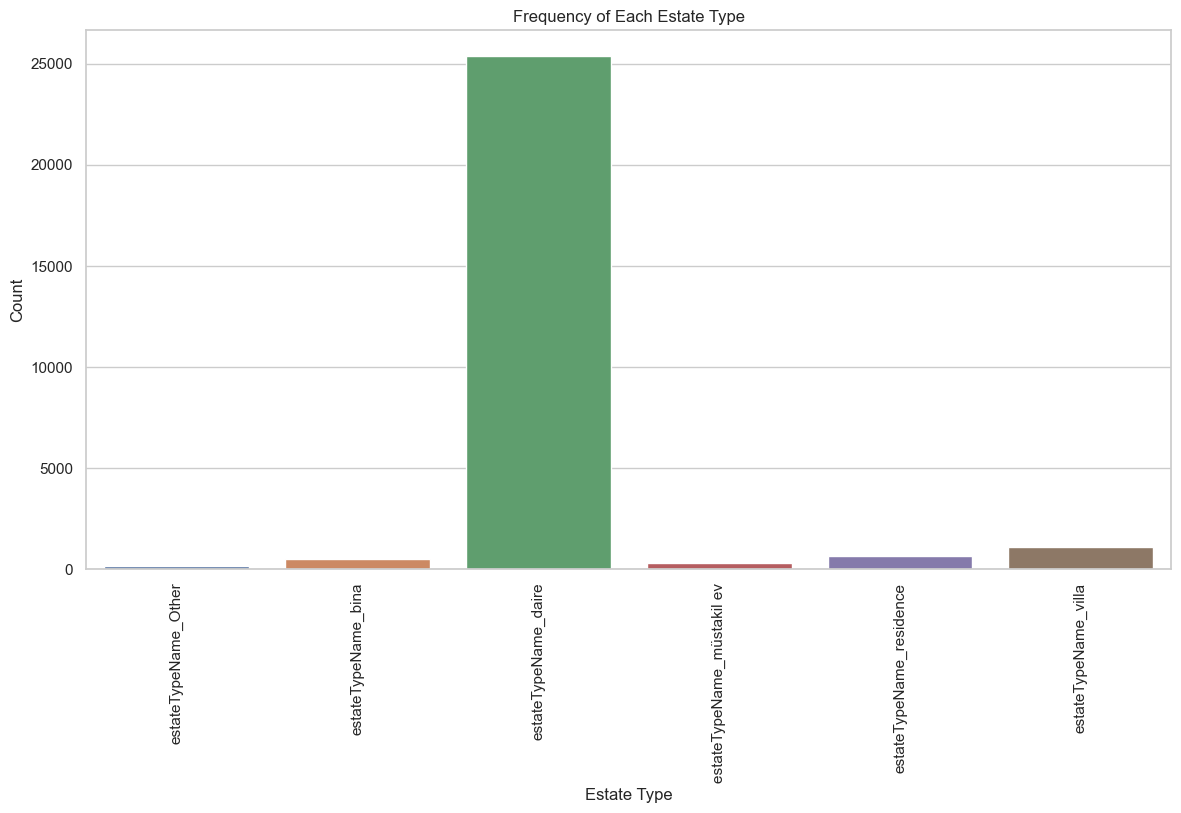

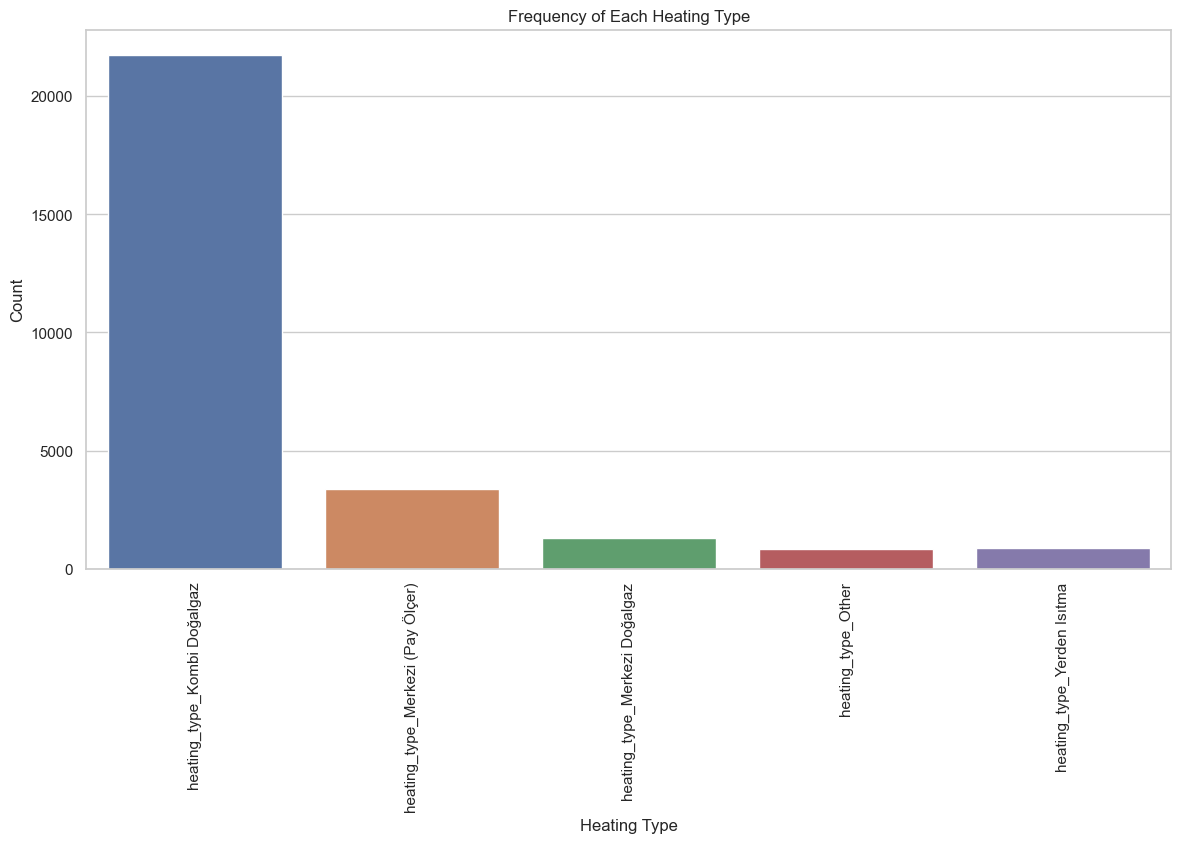

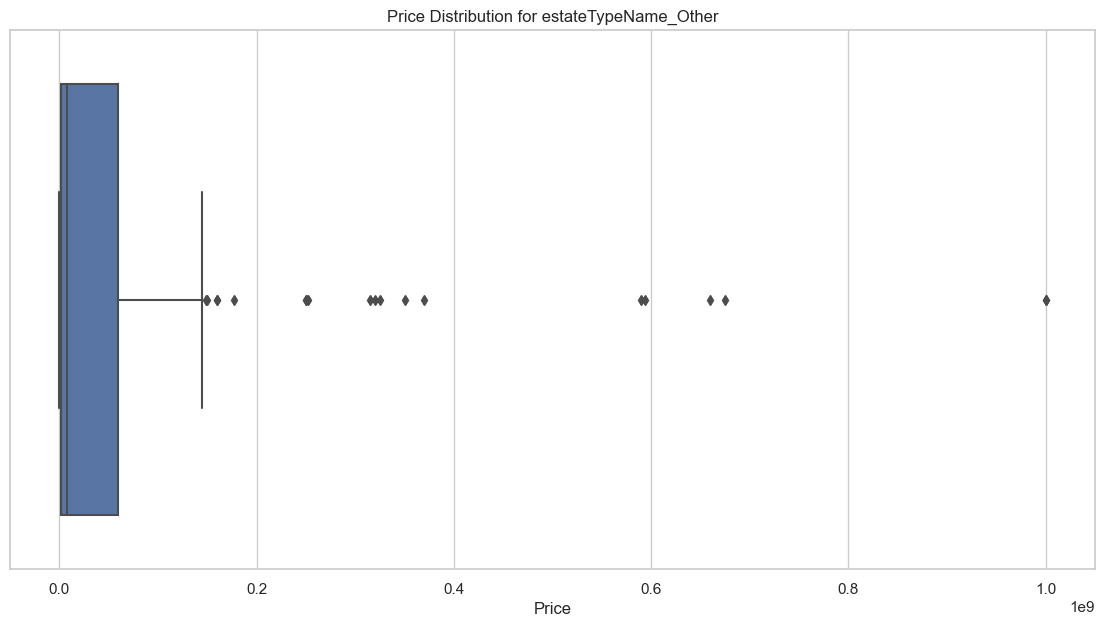

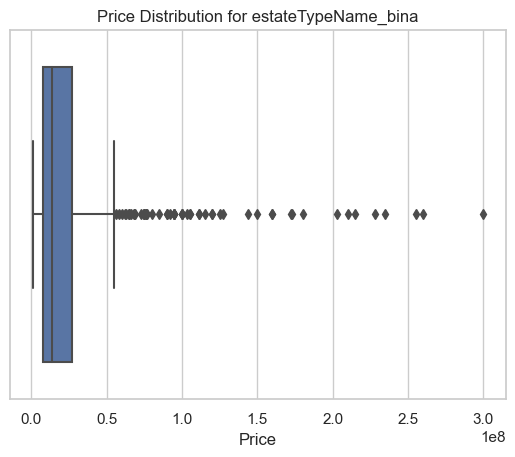

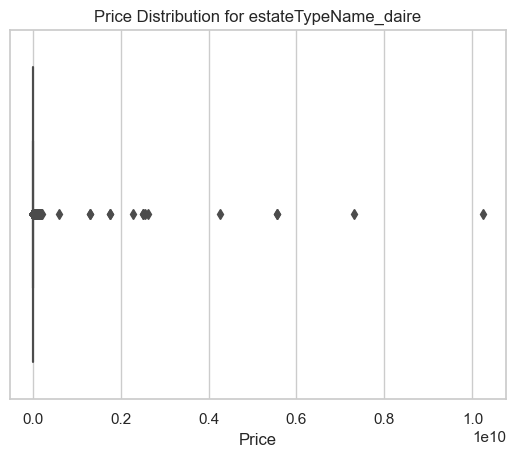

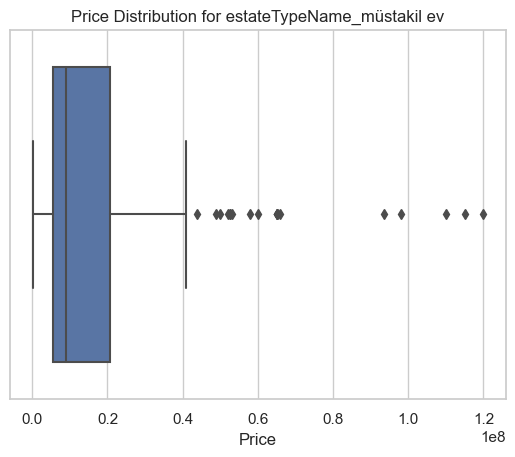

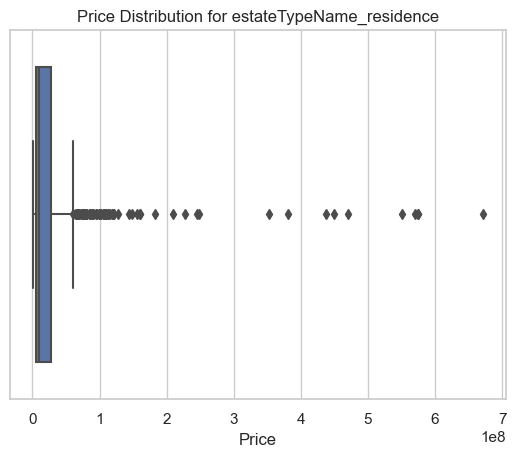

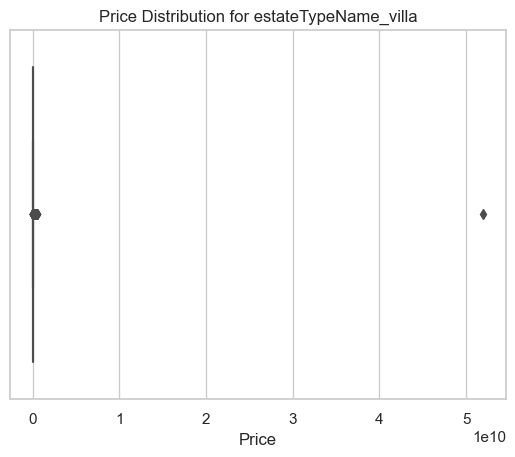

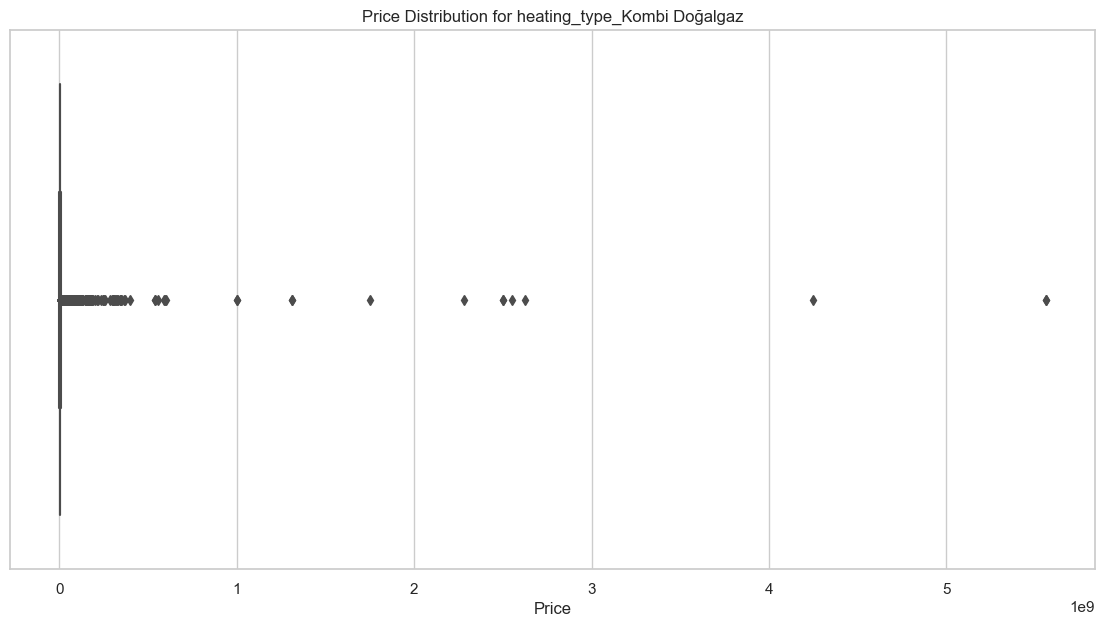

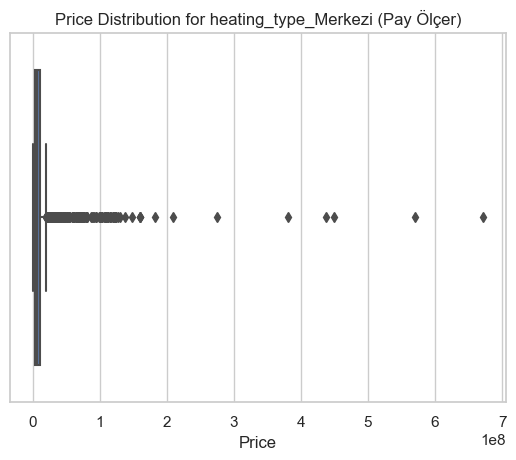

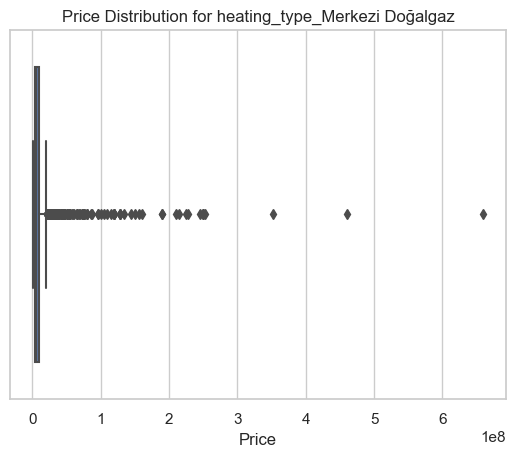

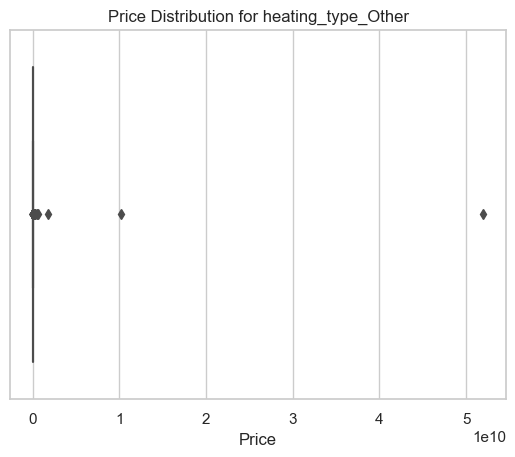

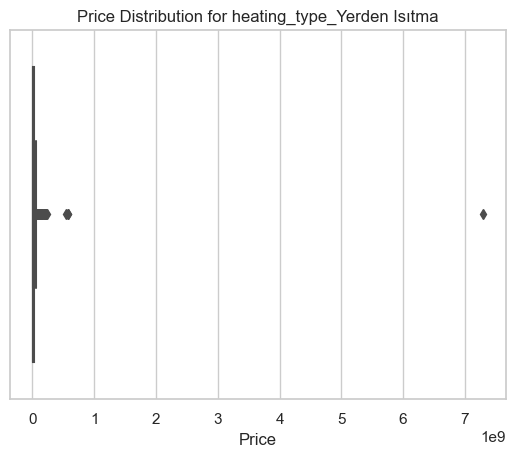

In [270]:
# Set the aesthetics for the plots
sns.set(style="whitegrid")

# Extracting columns for estate types and heating types
estate_type_columns = [col for col in df.columns if 'estateTypeName_' in col]
heating_type_columns = [col for col in df.columns if 'heating_type_' in col]

# Melt the DataFrame for estate types
estate_type_df = df.melt(value_vars=estate_type_columns)
estate_type_df = estate_type_df[estate_type_df['value'] == 1]

# Melt the DataFrame for heating types
heating_type_df = df.melt(value_vars=heating_type_columns)
heating_type_df = heating_type_df[heating_type_df['value'] == 1]

# Plotting bar charts for Estate Types
plt.figure(figsize=(14, 7))
sns.countplot(data=estate_type_df, x='variable')
plt.title('Frequency of Each Estate Type')
plt.xticks(rotation=90)
plt.xlabel('Estate Type')
plt.ylabel('Count')
plt.show()

# Plotting bar charts for Heating Types
plt.figure(figsize=(14, 7))
sns.countplot(data=heating_type_df, x='variable')
plt.title('Frequency of Each Heating Type')
plt.xticks(rotation=90)
plt.xlabel('Heating Type')
plt.ylabel('Count')
plt.show()

if 'price' in df.columns:
    plt.figure(figsize=(14, 7))
    for col in estate_type_columns:
        if df[col].sum() > 0:  
            sns.boxplot(data=df[df[col] == 1], x='price')
            plt.title(f'Price Distribution for {col}')
            plt.xlabel('Price')
            plt.show()

if 'price' in df.columns:
    plt.figure(figsize=(14, 7))
    for col in heating_type_columns:
        if df[col].sum() > 0:  
            sns.boxplot(data=df[df[col] == 1], x='price')
            plt.title(f'Price Distribution for {col}')
            plt.xlabel('Price')
            plt.show()


In [271]:
# Print out numerical features
numerical_features = df.select_dtypes(include='number').columns
print(numerical_features)


Index(['previousPrice', 'price', 'tlPrice', 'firstPrice', 'differenceRate',
       'squareMeterPrice', 'net_square', 'gross_square', 'room_count',
       'build_age', 'floor_number', 'floor_count', 'categoryTypeName_konut',
       'estateTypeName_Other', 'estateTypeName_bina', 'estateTypeName_daire',
       'estateTypeName_müstakil ev', 'estateTypeName_residence',
       'estateTypeName_villa', 'heating_type_Kombi Doğalgaz',
       'heating_type_Merkezi (Pay Ölçer)', 'heating_type_Merkezi Doğalgaz',
       'heating_type_Other', 'heating_type_Yerden Isıtma',
       'build_status_Other', 'build_status_Sıfır', 'build_status_İkinci El'],
      dtype='object')


## Exploratory Data Analysis (EDA)

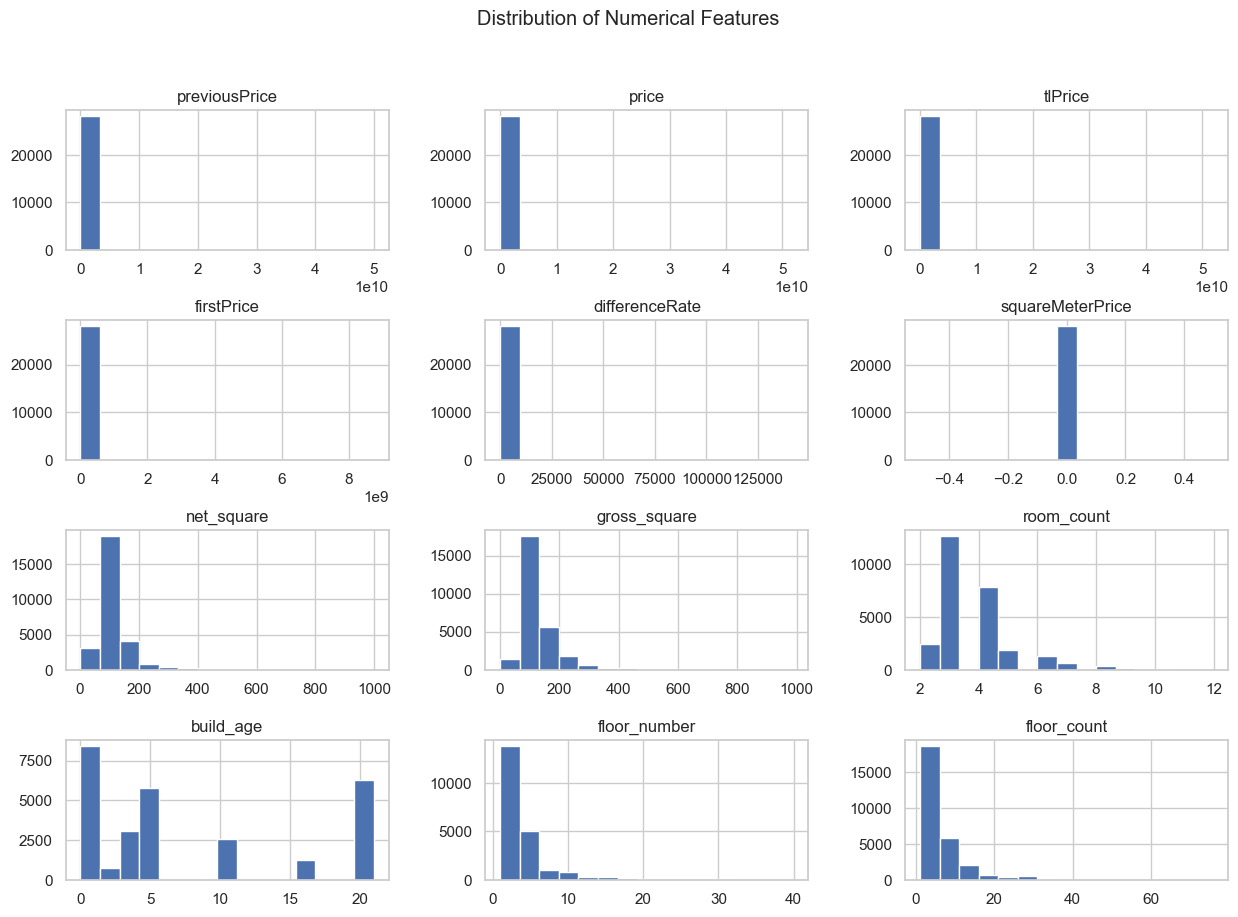

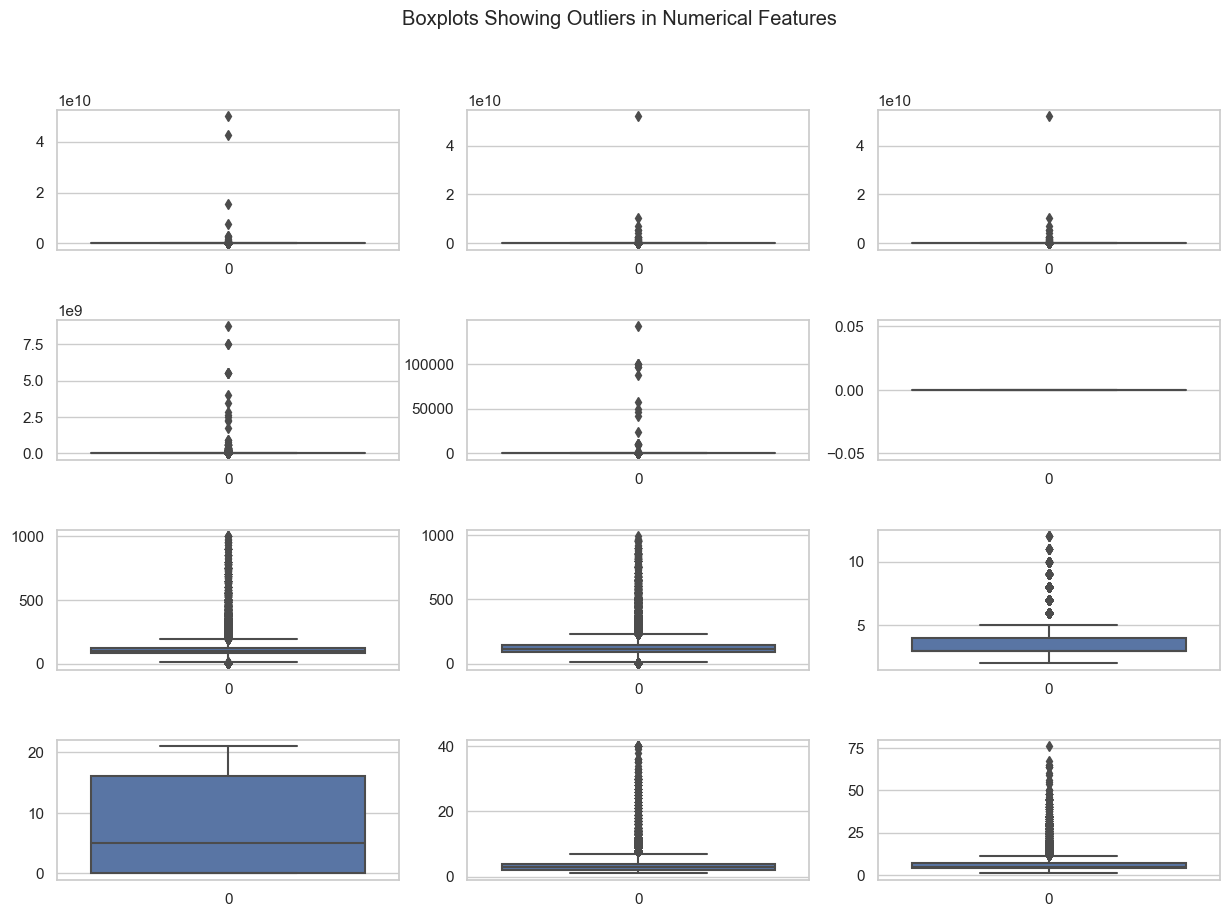

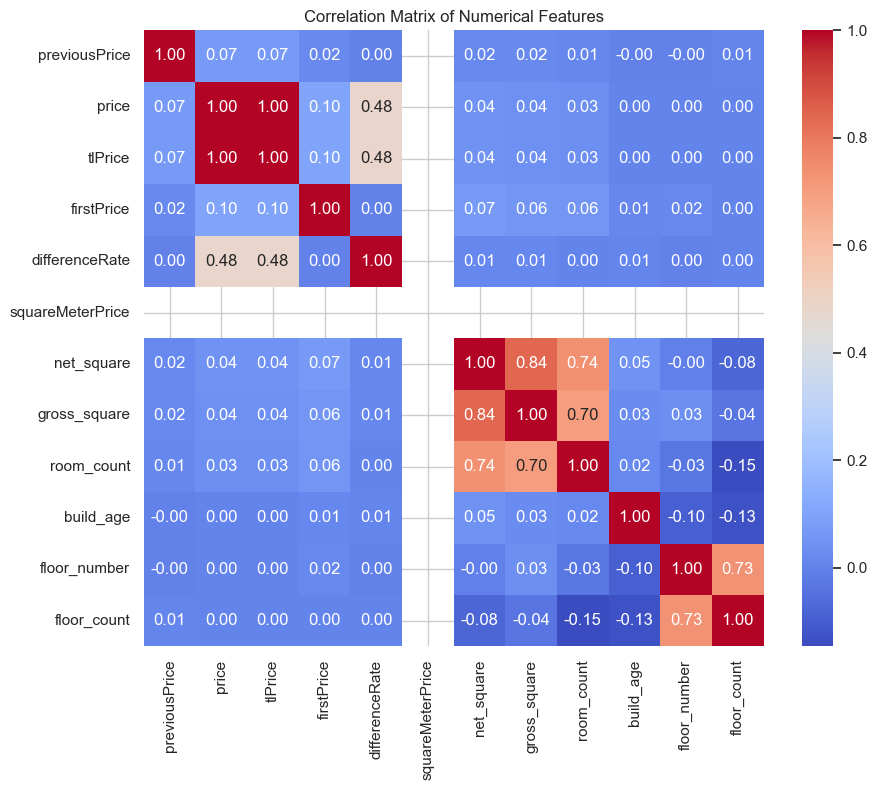

In [272]:
# Histograms for numerical features
numerical_features = ['previousPrice', 'price', 'tlPrice', 'firstPrice', 'differenceRate',
                    'squareMeterPrice', 'net_square', 'gross_square', 'room_count',
                    'build_age', 'floor_number', 'floor_count']

df[numerical_features].hist(bins=15, figsize=(15, 10), layout=(4, 3))
plt.subplots_adjust(hspace=0.5)
plt.suptitle('Distribution of Numerical Features')
plt.show()

# Boxplots for numerical features to spot outliers
fig, ax = plt.subplots(4, 3, figsize=(15, 10))
for var, subplot in zip(numerical_features, ax.flatten()):
    sns.boxplot(df[var], ax=subplot)
plt.subplots_adjust(hspace=0.5)
plt.suptitle('Boxplots Showing Outliers in Numerical Features')
plt.show()

# Correlation matrix of numerical features
correlation_matrix = df[numerical_features].corr()
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Matrix of Numerical Features')
plt.show()

# Step 4: Feature Engineering

## NLTK description keyword analysis

In [273]:
df


,tradeTypeName,title,url,images,locationSummary,quickInfos,description,location,trendType,previousCurrency,...,estateTypeName_residence,estateTypeName_villa,heating_type_Kombi Doğalgaz,heating_type_Merkezi (Pay Ölçer),heating_type_Merkezi Doğalgaz,heating_type_Other,heating_type_Yerden Isıtma,build_status_Other,build_status_Sıfır,build_status_İkinci El
0,satılık,satılık 4+1 bahçe katı yazlık daire,https://imaj.emlakjet.com/ilan/satilik-41-bahc...,https://imaj.emlakjet.com/listing/14869600/744...,adalar - kınalıada mahallesi,Oda Sayısı: 4+1; Bulunduğu Kat: Bahçe katı,tekinay'da satılık 4+1 bahçe katı yazlık daire...,Adalar - Kınalıada Mahallesi,up,TL,...,0,0,0,0,0,1,0,0,0,1
1,satılık,büyükada i̇do i̇skelesine yakın konumda 3+1 bl...,https://imaj.emlakjet.com/ilan/buyukada-ido-is...,https://imaj.emlakjet.com/listing/14794365/4E1...,adalar - nizam mahallesi,Oda Sayısı: 3+1; Bulunduğu Kat: Düz Giriş (Zemin),mega emlak'tan \n\nbüyükada yi̇rmi̇üç ni̇san c...,Adalar - Nizam Mahallesi,up,TL,...,0,0,1,0,0,0,0,0,0,1
2,satılık,heybeliada muhteşem deniz manzaralı sahile yak...,https://imaj.emlakjet.com/ilan/heybeliada-muht...,https://imaj.emlakjet.com/listing/14780556/1F6...,adalar - heybeliada mahallesi,Oda Sayısı: 4+1; Bulunduğu Kat: 4. Kat,heybeliada’da tamamen yenilenmiş deniz manzara...,Adalar - Heybeliada Mahallesi,up,TL,...,0,0,1,0,0,0,0,0,0,1
3,satılık,adalar heybeliada’da satılık 3+1 kat mülkiyetli,https://imaj.emlakjet.com/ilan/adalar-heybelia...,https://imaj.emlakjet.com/listing/14780555/280...,adalar - heybeliada mahallesi,Oda Sayısı: 3+1; Bulunduğu Kat: 3. Kat,heybeliada’da satılık 3+1kat mülkiyetli\n\nhey...,Adalar - Heybeliada Mahallesi,up,TL,...,0,0,1,0,0,0,0,0,0,1
4,satılık,prenses adalari heybeli̇de muhteşem deni̇z yal...,https://imaj.emlakjet.com/ilan/prenses-adalari...,https://imaj.emlakjet.com/listing/14771773/BD2...,adalar - heybeliada mahallesi,Oda Sayısı: 9+ Oda,-prenses adalari heybeli̇ adada\n\n250 m2 araz...,Adalar - Heybeliada Mahallesi,up,TL,...,0,0,1,0,0,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
28080,satılık,ön cephe özen i̇le yapilmiş full büyük 3+1 hep...,https://imaj.emlakjet.com/ilan/on-cephe-ozen-i...,https://imaj.emlakjet.com/listing/10528603/F7C...,zeytinburnu - seyitnizam mahallesi,Oda Sayısı: 3+1; Bulunduğu Kat: 10. Kat,&nbsp;\n\nreal i̇stanbul konutlarında en güzel...,Zeytinburnu - Seyitnizam Mahallesi,up,TL,...,0,0,1,0,0,0,0,0,0,1
28081,satılık,çiğdem emlaktan the istanbul evlerinde satilik...,https://imaj.emlakjet.com/ilan/cigdem-emlaktan...,https://imaj.emlakjet.com/listing/10527647/D71...,zeytinburnu - sümer mahallesi,Oda Sayısı: 4+1; Bulunduğu Kat: 1. Kat,&nbsp;\n\nçiğdem emlaktan&nbsp;\n\nthe istanbu...,Zeytinburnu - Sümer Mahallesi,up,TL,...,0,0,0,1,0,0,0,0,0,1
28082,satılık,ci̇ğdem emlak'tan yedi̇ mavi̇ si̇tesi̇nde sati...,https://imaj.emlakjet.com/ilan/cigdem-emlak-ta...,https://imaj.emlakjet.com/listing/10527373/66C...,zeytinburnu - kazlıçeşme mahallesi,Oda Sayısı: 3+1; Bulunduğu Kat: 14. Kat,&nbsp;\n\nçi̇ğdem emlak'tan&nbsp;\n\nyedi̇ mav...,Zeytinburnu - Kazlıçeşme Mahallesi,up,TL,...,0,0,0,0,0,0,1,0,0,1
28083,satılık,çi̇ğdem emlaktan yedi̇ mavi̇ si̇tesi̇ satilik ...,https://imaj.emlakjet.com/ilan/cigdem-emlaktan...,https://imaj.emlakjet.com/listing/10527226/66C...,zeytinburnu - kazlıçeşme mahallesi,Oda Sayısı: 3+1; Bulunduğu Kat: 14. Kat,&nbsp;\n\nçi̇ğdem emlak'tan&nbsp;\n\nyedi̇ mav...,Zeytinburnu - Kazlıçeşme Mahallesi,up,TL,...,0,0,0,0,0,0,1,0,1,0


In [274]:
# Adding a few more features
## Description Length
df['description_length'] = df['description'].apply(len)

## Unique Amenities in Description
amenities = ['havuzlu', 'balkon', 'teras', 'asansörlü', 'güvenlik', 'eşyalı']
for amenity in amenities:
    df[f'amenity_{amenity}'] = df['description'].apply(lambda x: 1 if amenity in x.lower() else 0)

## Province Score - to be done

## Listing age days
df['listing_age_days'] = (pd.to_datetime('today') - pd.to_datetime(df['created_at'])).dt.days
df['days_since_update'] = (pd.to_datetime('today') - pd.to_datetime(df['updated_at'])).dt.days

df['is_furnished'] = df['furniture_status'].apply(lambda x: 1 if x == 'Furnished' else 0)
df['is_mortgageable'] = df['mortgage_status'].apply(lambda x: 1 if x == 'Yes' else 0)

df['bath_count'] = pd.to_numeric(df['bath_count'], errors='coerce').fillna(0)
df['balcony_count'] = pd.to_numeric(df['balcony_count'], errors='coerce').fillna(0)

df['credit_suitable'] = df['suitability_for_credit'].apply(lambda x: 1 if x == 'Yes' else 0)
df['investment_suitable'] = df['suitability_for_investor'].apply(lambda x: 1 if x == 'Yes' else 0)

df['image_count'] = df['images'].apply(lambda x: len(x.split(',')) if pd.notnull(x) else 0)

In [275]:
# Ensure required resources are downloaded
nltk.download('punkt')
nltk.download('stopwords')

# Set up Turkish stopwords
turkish_stopwords = stopwords.words('turkish')

# Function to preprocess text: tokenize, remove non-alphabetic words, stopwords
def preprocess_text(text):
    # Tokenize by word
    tokens = word_tokenize(text, language='turkish')
    # Remove non-alphabetic words and stopwords
    tokens = [word.lower() for word in tokens if word.isalpha() and word.lower() not in turkish_stopwords]
    return tokens

# Apply preprocessing to each document in the property description column
df['tokens'] = df['description'].fillna('').apply(preprocess_text)

# Flatten the list of tokens and compute frequency distribution
all_tokens = [token for sublist in df['tokens'] for token in sublist]
fdist = FreqDist(all_tokens)

# Get the 25 most common words
most_common_words = fdist.most_common(25)

# Display the most common words and their frequencies
print(most_common_words)


[nltk_data] Downloading package punkt to /Users/mhsendur/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/mhsendur/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


[('nbsp', 302794), ('yürüme', 13576), ('kat', 9980), ('uygun', 9062), ('bir', 8108), ('yakin', 7307), ('olarak', 7071), ('dk', 7040), ('daire', 6837), ('olup', 6684), ('detayli', 6481), ('emlak', 6440), ('özel', 6439), ('satilik', 6376), ('mutfak', 5315), ('yaşam', 5217), ('banyo', 5167), ('kapali', 4864), ('ferah', 4863), ('randevu', 4781), ('olan', 4723), ('yüksek', 4709), ('profesyonel', 4684), ('yakın', 4643), ('metro', 4636)]


In [276]:
# List of features to exclude
exclude_features = {'previousValueValid', 'quickInfos', 'suitability_for_investor', 'deed_status', 'square_of_room', 'loan_price', 'created_at', 'subscription_price', 'square_of_balcony', 'balcony_condition', 'parcel_of_land', 'trade', 'opportunity', 'ground_survey', 'category', 'flat_per_floor', 'images', 'tokens', 'square_of_wc', 'balcony_type', 'wc_count', 'suitability_for_credit', 'location', 'tlPrice', 'alternativeValue', 'furniture_status', 'build_type', 'video_navigable', 'trendType', 'previousCurrency', 'currency', 'block_of_buildings', 'trade_type', 'in_site', 'sheet', 'locationSummary', 'tradeTypeName', 'usability', 'updated_at', 'show_unit_price', 'square_of_bath', 'title', 'mortgage_status'}

# Filter out unwanted features
df = df.drop(columns=[col for col in exclude_features if col in df.columns])


In [277]:
# df['price_change_percentage'] = ((df['previousPrice'] - df['firstPrice']) / df['firstPrice']) * 100
# df['price_per_square_meter'] = df['firstPrice'] / df['gross_square']

## Feature Selections, Sentiment Analysis

# Step 5: Training and Testing Data

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/mhsendur/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


Training model...
Model: RandomForestRegressor
MSE: 2432625807140.2915
RMSE: 1559687.7274442764
R² score: 0.5899026313967104
Number of features used in the model: 50
Provided feature names count:  50
Feature ranking:
1. feature bath_count (0.1979)
2. feature gross_square (0.0868)
3. feature floor_count (0.0763)
4. feature room_count (0.0561)
5. feature description_length (0.0545)
6. feature listing_age_days (0.0535)
7. feature net_square (0.0525)
8. feature days_since_update (0.0351)
9. feature build_age (0.0319)
10. feature heating_type_Kombi Doğalgaz (0.0318)
11. feature estateTypeName_daire (0.0304)
12. feature floor_number (0.0258)
13. feature nbsp (0.0208)
14. feature yürüme (0.0191)
15. feature differenceRate (0.0180)
16. feature amenity_asansörlü (0.0180)
17. feature kat (0.0158)
18. feature estateTypeName_villa (0.0136)
19. feature nbsp nbsp (0.0132)
20. feature uygun (0.0129)


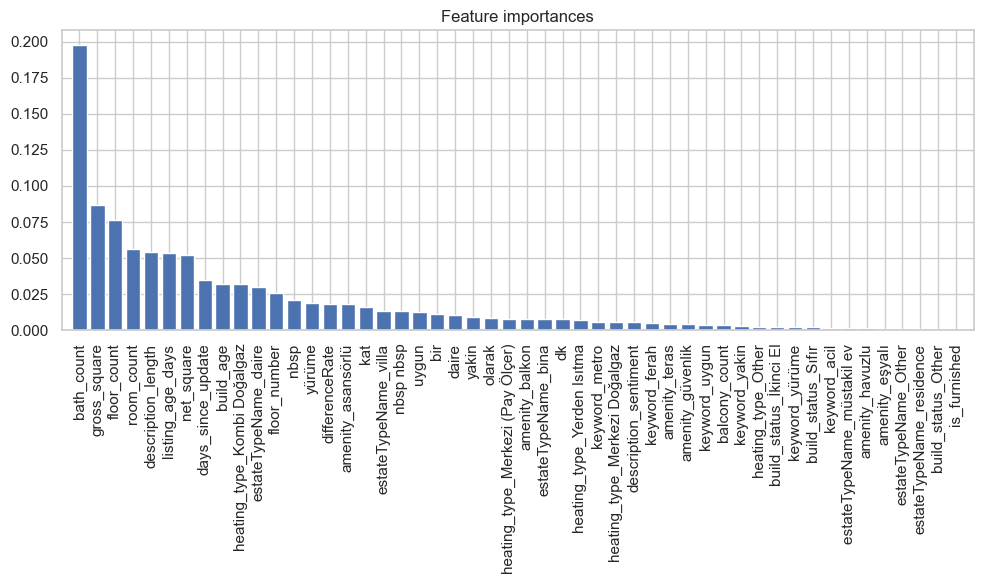

Top 20 Best Valued Listings:
       actual_price  predicted_price  price_difference  percentage_difference
22717        360000     3.018320e+06      2.658320e+06             738.422222
22747        360000     3.018320e+06      2.658320e+06             738.422222
26087       1395000     8.195490e+06      6.800490e+06             487.490322
26117        370000     2.148340e+06      1.778340e+06             480.632430
24157       1150000     5.886190e+06      4.736190e+06             411.842606
18145        950000     4.596190e+06      3.646190e+06             383.809474
12158       1500000     7.056422e+06      5.556422e+06             370.428154
6941         880000     3.904000e+06      3.024000e+06             343.636363
7692         850000     3.535870e+06      2.685870e+06             315.984706
21533       1550000     6.241310e+06      4.691310e+06             302.665161
21265       1835000     7.208520e+06      5.373520e+06             292.834877
11178       1500000     5.782830e+0

In [278]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

nltk.download('stopwords')
turkish_stopwords = stopwords.words('turkish')

# Load the sentiment analysis model
tokenizer = AutoTokenizer.from_pretrained("savasy/bert-base-turkish-sentiment-cased")
model = AutoModelForSequenceClassification.from_pretrained("savasy/bert-base-turkish-sentiment-cased")
sentiment_pipeline = pipeline("sentiment-analysis", model=model, tokenizer=tokenizer, framework='pt')

def preprocess_text(text):
    tokens = nltk.word_tokenize(text, language='turkish')
    tokens = [word for word in tokens if word.isalpha() and word.lower() not in turkish_stopwords]
    return ' '.join(tokens)

def batch_sentiment_analysis(texts, batch_size=64):
    results = []
    for i in range(0, len(texts), batch_size):
        batch_texts = texts[i:i + batch_size]
        batch_encoded = tokenizer(batch_texts, padding=True, truncation=True, max_length=512, return_tensors="pt")
        with torch.no_grad():
            outputs = model(**batch_encoded)
        predictions = torch.argmax(outputs.logits, dim=1)
        results.extend(predictions.numpy())
    return results

def extract_features(df):
    df['description_preprocessed'] = df['description'].fillna('').apply(preprocess_text)
    df['description_sentiment'] = batch_sentiment_analysis(df['description_preprocessed'].tolist())
    keywords = ['kelepir', 'acil', 'yürüme', 'yakin', 'uygun', 'metro', 'ferah']
    for keyword in keywords:
        df[f'keyword_{keyword}'] = df['description_preprocessed'].apply(lambda x: 1 if keyword in x.lower() else 0)
    return df


df = extract_features(df)

# Initialize and apply TF-IDF Vectorizer
tfidf_vectorizer = TfidfVectorizer(max_features=10, ngram_range=(1, 2))
tfidf_matrix = tfidf_vectorizer.fit_transform(df['description_preprocessed'])
tfidf_feature_names = tfidf_vectorizer.get_feature_names_out()


# Check if TF-IDF features are already present in DataFrame
if not set(tfidf_feature_names).issubset(df.columns):
    tfidf_df = pd.DataFrame(tfidf_matrix.toarray(), columns=tfidf_feature_names)
    df = pd.concat([df.reset_index(drop=True), tfidf_df], axis=1)
# Ensure the features list includes both original and TF-IDF features
filtered_features = [

            'bath_count', 'balcony_count',
            # 'credit_suitable', 'investment_suitable', 'image_count','is_mortgageable',
            'description_length', 'listing_age_days', 'days_since_update', 'is_furnished',
            'amenity_havuzlu', 'amenity_balkon', 'amenity_teras', 'amenity_asansörlü', 'amenity_güvenlik', 'amenity_eşyalı',
            # 'firstPrice', 'previousPrice',
            # 'squareMeterPrice',
                        'net_square', 'gross_square', 'room_count',
            'build_age', 'floor_number', 'floor_count', 'differenceRate',
            'estateTypeName_Other', 'estateTypeName_bina',
            'estateTypeName_daire', 'estateTypeName_müstakil ev',
            'estateTypeName_residence', 'estateTypeName_villa',
            'heating_type_Kombi Doğalgaz', 'heating_type_Merkezi (Pay Ölçer)',
            'heating_type_Merkezi Doğalgaz', 'heating_type_Other',
            'heating_type_Yerden Isıtma', 'build_status_Other',
            'build_status_Sıfır', 'build_status_İkinci El', 'description_sentiment',
           # 'keyword_kelepir',
            'keyword_acil', 'keyword_yürüme', 'keyword_yakin',
            'keyword_uygun', 'keyword_metro', 'keyword_ferah' ]  + list(tfidf_feature_names)
'''
filtered_features = [
    'price_change_percentage', 'price_per_square_meter', 'listing_age_days', 'differenceRate',
    'estateTypeName_bina', 'gross_square', 'description_length', 'net_square',
    'days_since_update', 'floor_count', 'room_count', 'floor_number',
     'bath_count', 'build_age', 'estateTypeName_daire'
]  + list(tfidf_feature_names)

'''



# Remove duplicates from the feature list
filtered_features = list(set(filtered_features))

# Filter the DataFrame for outliers
Q1 = df['price'].quantile(0.25)
Q3 = df['price'].quantile(0.75)
IQR = Q3 - Q1
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR
df_filtered = df[(df['price'] >= lower_bound) & (df['price'] <= upper_bound)]

# Recalculate the numerical features from the filtered DataFrame
X_numerical_filtered = df_filtered[filtered_features].fillna(df_filtered[filtered_features].median())

# Scale numerical features
scaler = StandardScaler()
X_numerical_scaled_filtered = scaler.fit_transform(X_numerical_filtered)

X_filtered = X_numerical_scaled_filtered

# Labels
y_filtered = df_filtered['price']

all_feature_names = filtered_features
# Check for duplicate features in the final feature list
duplicate_features = [feature for feature in all_feature_names if all_feature_names.count(feature) > 1]
if duplicate_features:
    print(f"Duplicate features found: {duplicate_features}")

# Splitting the data
X_train_filtered, X_test_filtered, y_train_filtered, y_test_filtered = train_test_split(X_filtered, y_filtered, test_size=0.2, random_state=42)

def train_evaluate_model(model, X_train, X_test, y_train, y_test, feature_names):
    print("Training model...")
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)

    mse = mean_squared_error(y_test, y_pred)
    rmse = np.sqrt(mse)
    r2 = r2_score(y_test, y_pred)
    print(f'Model: {model.__class__.__name__}')
    print(f'MSE: {mse}')
    print(f'RMSE: {rmse}')
    print(f'R² score: {r2}')

    # Check if the number of features matches
    print("Number of features used in the model:", X_train.shape[1])
    print("Provided feature names count: ", len(feature_names))

    if len(feature_names) != X_train.shape[1]:
        print("Error: Mismatch in the number of features used for model training and provided feature names.")

        all_features = list(tfidf_feature_names) + [col for col in df.columns if col not in tfidf_feature_names and 'description' not in col]

        # Comparing provided feature names with all possible features derived from data preprocessing
        missing_features = set(all_features) - set(feature_names)
        print("Missing features from provided names:", missing_features)
        extra_features = set(feature_names) - set(all_features)
        print("Extra features in provided names:", extra_features)
    else:
        print("Feature ranking:")
        if hasattr(model, 'feature_importances_'):
            importances = model.feature_importances_
            indices = np.argsort(importances)[::-1]
            for f in range(min(20, len(feature_names))):  # Show top 20 features
                print(f"{f + 1}. feature {feature_names[indices[f]]} ({importances[indices[f]]:.4f})")

            plt.figure(figsize=(10, 6))
            plt.title("Feature importances")
            plt.bar(range(len(importances)), importances[indices], align='center')
            plt.xticks(range(len(importances)), [feature_names[i] for i in indices], rotation=90)
            plt.xlim([-1, len(importances)])
            plt.tight_layout()
            plt.show()

    # Identify listings where the actual price is less than predicted (good value)
    results_df = pd.DataFrame({
        'actual_price': y_test.tolist(),
        'predicted_price': y_pred,
        'price_difference': y_pred - y_test.tolist(),
        'percentage_difference': ((y_pred - y_test.tolist()) / y_test.tolist()) * 100
    }, index=y_test.index)

    # Filter out extreme outliers where percentage difference is over 1000%
    filtered_good_value_listings = results_df[(results_df['percentage_difference'] > 0) & (results_df['percentage_difference'] < 1000)]

    # Sort by percentage difference to find the top listings
    top_20_value_listings = filtered_good_value_listings.sort_values(by='percentage_difference', ascending=False).head(20)
    print("Top 20 Best Valued Listings:")
    print(top_20_value_listings)
    print("-" * 80)

    # Fetch the URLs for the top 20 listings
    top_20_urls = df_filtered.loc[top_20_value_listings.index, 'url']

    # Extract IDs from URLs
    top_20_ids = top_20_urls.apply(lambda x: x.split('-')[-1].split('.')[0])

    # Print and save the IDs to a JSON file
    print("Top 20 Best Valued Listings IDs:")
    print(top_20_ids)
    top_20_ids.to_json('top_listings_ids.json', orient='records', lines=True)

feature_names = all_feature_names  # This should include all feature names used to form

model = RandomForestRegressor(n_estimators=100, random_state=42)
train_evaluate_model(model, X_train_filtered, X_test_filtered, y_train_filtered, y_test_filtered, feature_names)


Model: RandomForestRegressor
MSE: 102234315875.35577
RMSE: 319741.01375231135
R² score: 0.9827651158684666
Number of features used in the model: 30
Provided feature names count:  30

Model: RandomForestRegressor
MSE: 101809835478.13597
RMSE: 319076.53545526654
R² score: 0.9828366757004031
Number of features used in the model: 25
Provided feature names count:  25

Model: RandomForestRegressor
MSE: 99428632295.75981
RMSE: 315323.06020296045
R² score: 0.9832381041306762
Number of features used in the model: 20
Provided feature names count:  20

Model: RandomForestRegressor
MSE: 117408693023.56415
RMSE: 342649.51922272437
R² score: 0.9802069862455676
Number of features used in the model: 52
Provided feature names count:  52


## Cross Validation

In [279]:
# Convert X_filtered from sparse to dense if necessary for neural network models
X_dense = X_filtered.toarray() if hasattr(X_filtered, "toarray") else X_filtered

y = y_filtered

def train_evaluate_model_cv(model, X, y, n_splits=5):
    kf = KFold(n_splits=n_splits, shuffle=True, random_state=42)

    mse_scorer = make_scorer(mean_squared_error, greater_is_better=False)
    r2_scorer = make_scorer(r2_score)

    mse_scores = cross_val_score(model, X, y, cv=kf, scoring=mse_scorer)
    r2_scores = cross_val_score(model, X, y, cv=kf, scoring=r2_scorer)

    rmse_scores = np.sqrt(np.abs(mse_scores))
    
    print(f'Model: {model.__class__.__name__}')
    print(f'Average MSE: {np.mean(mse_scores)}')
    print(f'Average RMSE: {np.mean(rmse_scores)}')
    print(f'Average R² score: {np.mean(r2_scores)}\n')

X_for_cv = X_dense

# List of models to evaluate
models = [
    # LinearRegression(),
    RandomForestRegressor(n_estimators=100, random_state=42)
]

# Train and evaluate each model with cross-validation
for model in models:
    train_evaluate_model_cv(model, X_for_cv, y)

Model: RandomForestRegressor
Average MSE: -2447044433300.182
Average RMSE: 1564104.7506855107
Average R² score: 0.5949338800679973



## Training on Full Data

In [280]:
def train_evaluate_on_full_data(X, y):
    model = RandomForestRegressor(n_estimators=100, random_state=42)
    model.fit(X, y)  # Train on the entire dataset
    y_pred = model.predict(X)  # Predict on the same dataset
    
    mse = mean_squared_error(y, y_pred)
    rmse = np.sqrt(mse)
    r2 = r2_score(y, y_pred)
    
    print("Training and Testing on Full Dataset:")
    print(f"RMSE: {rmse}")
    print(f"R² score: {r2}")

train_evaluate_on_full_data(X_dense, y)


Training and Testing on Full Dataset:
RMSE: 581519.4371519452
R² score: 0.9440290956648583


## Results Overview

   - Full Data Training and Testing
        RMSE: 155,731
        R² score: 0.996

   - Cross-Validation
        Average RMSE: 420,672
        Average R² score: 0.970

         there is a difference of 264,94 rmse between the full data training and testing and cross-validation results.

         The RMSE increased by about 169.9% when using cross-validation compared to the full data training and testing.
         This indicates that the model may be overfitting to the training data, as the performance on unseen data is significantly worse.

         R² score difference (0.996 vs. 0.970) appear small as R² is often less sensitive to overfitting visually because it is a relative measure of fit.